### Model optimization for the PHELPH paper

grid search to dertermine the optimal regularization and reduced dimension

results are saved as mopt.npz files

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]
import time


data_path = "../../../data_PHELPH/"
derrom_path = "../../"

import sys

# sys.path.append(derrom_path)
sys.path.insert(0,derrom_path)

import derrom
from derrom.utils import ivp_integrator
import PHELPH

In [2]:
kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
dt = tmax/(n_tmax-1)
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0.04
system.tau_photon = 200
system.E_photon = 0.035
system.linewidth = 0.01

system.setup_laser()

In [42]:
I_trajectories = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_I_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_trajectories = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_el_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_scattering = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_el_scat_kmax2.5_nkmax_100_n1000_'+v+'.npz')

n_sample = 100

# I_trajectories = I_trajectories[::n_sample]
# el_trajectories = el_trajectories[::n_sample]
# el_scattering = el_scattering[::n_sample]

I_trajectories = I_trajectories[:n_sample]
el_trajectories = el_trajectories[:n_sample]
el_scattering = el_scattering[:n_sample]

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]

trajectories = [ np.concatenate([el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

mean_I_max = np.mean([I.max() for I in I_trajectories])
mean_I_max_pos = np.mean([np.argmax(I)*dt for I in I_trajectories])
median_I_max = np.median([I.max() for I in I_trajectories])
median_I_max_pos = np.median([np.argmax(I)*dt for I in I_trajectories])

100 loaded with n_kmax = 100


In [43]:
results_list = []

t_start = time.time()

for rdim in [2,4,6,8,10]:
    for alpha_exp in [0,1,2,3]:
        
        print('computing scores for rdim='+str(rdim)+', alpha_exp='+str(alpha_exp))

        dim_reducer = derrom.dim_reducers.SVD()

        scaler = derrom.scalers.standardize_scaler(1.0)
        transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
        optimizer = derrom.optimizers.ridge(alpha=10.**alpha_exp)

        el_scat_model = derrom.estimator(rdim=rdim, DE_l=2, intercept=True, full_hist=False,
                            optimizer=optimizer,
                            scaler=scaler,
                            dim_reducer=dim_reducer,
                            NL_transformer=transformer)

        def derivs(y):   
            el_hist = y[:,:-1]
            el_state = y[-1,:-1]
            I = y[-1,-1]

            df = el_scat_model.predict(el_hist)
            df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)


            dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
            dI += 1e-9

            return np.concatenate((df[0],[dI]))

        integrator = derrom.utils.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

        scores = derrom.utils.get_KFold_CV_scores(integrator, trajectories, el_scattering, folds=10, seed=817,
                                                  norms=['rms','I_max','I_max_pos','I_max_rel','I_max_pos_rel'],
                                                  train_kwargs={})

        results = np.array([[np.mean(np.abs(scrs)) for scrs in scores],[np.std(np.abs(scrs)) for scrs in scores]]).T
        
        I_max_err_median = np.median(np.abs(scores[1]))
        I_max_err_90th = np.percentile(np.abs(scores[1]), 90)
        tmp = np.reshape(np.array([I_max_err_median,I_max_err_90th]),(1,2)) 
        results = np.concatenate((results,tmp),axis=0)
        
        I_max_pos_err_median = np.median(np.abs(scores[2]))
        I_max_pos_err_90th = np.percentile(np.abs(scores[2]), 90)
        tmp = np.reshape(np.array([I_max_pos_err_median,I_max_pos_err_90th]),(1,2))
        results = np.concatenate((results,tmp),axis=0)
        
        results_list.append(results)
        
        
t_end = time.time()
print("computation time:", t_end - t_start)

computing scores for rdim=2, alpha_exp=0
computing scores for rdim=2, alpha_exp=1


/tmp/ipykernel_3596781/3929108424.py:28: RuntimeWarning: overflow encountered in multiply
  df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
/tmp/ipykernel_3596781/3929108424.py:31: RuntimeWarning: overflow encountered in double_scalars
  dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
../derrom/derrom/utils.py:503: RuntimeWarning: overflow encountered in multiply
  vecs = np.stack( [hist[(hist_ind - n*j_out + hist_length)%hist_length] for n in range(self.model.DE_l-1,0,-1)]+[(state+dt*f1).flatten()] )
../derrom/derrom/dim_reducers.py:77: RuntimeWarning: invalid value encountered in matmul
  return data_matrix @ self.U[:,:rdim] #project the data matrix onto the first rdim left singular vectors. The reduced data matrix then carries rdim coefficients in its rows
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwa

computing scores for rdim=2, alpha_exp=2
computing scores for rdim=2, alpha_exp=3
computing scores for rdim=4, alpha_exp=0
computing scores for rdim=4, alpha_exp=1
computing scores for rdim=4, alpha_exp=2
computing scores for rdim=4, alpha_exp=3
computing scores for rdim=6, alpha_exp=0
computing scores for rdim=6, alpha_exp=1
computing scores for rdim=6, alpha_exp=2
computing scores for rdim=6, alpha_exp=3
computing scores for rdim=8, alpha_exp=0
computing scores for rdim=8, alpha_exp=1
computing scores for rdim=8, alpha_exp=2
computing scores for rdim=8, alpha_exp=3
computing scores for rdim=10, alpha_exp=0
computing scores for rdim=10, alpha_exp=1
computing scores for rdim=10, alpha_exp=2
computing scores for rdim=10, alpha_exp=3
computation time: 1669.469484090805


In [44]:
results_array = np.asarray(results_list)
print(results_array.shape)
results_array = results_array.reshape((5,4,7,2))
print(results_array.shape)

(20, 7, 2)
(5, 4, 7, 2)


In [37]:
# np.save(data_path+'mopt_n10', results_array)

In [55]:
results_array = np.load(data_path+'mopt_n50.npy')
print(results_array.shape)

(5, 3, 7, 2)


In [45]:
el_rms_err = results_array[:,:,0,0] + results_array[:,:,0,1]
I_max_err = results_array[:,:,1,0] + results_array[:,:,1,1]
I_max_pos_err = results_array[:,:,2,0] + results_array[:,:,2,1]
I_max_rel_err = results_array[:,:,3,0] + results_array[:,:,3,1]
I_max_pos_rel_err = results_array[:,:,4,0] + results_array[:,:,4,1]
I_max_err_90th = results_array[:,:,5,1]
I_max_pos_err_90th = results_array[:,:,6,1]

In [46]:
I_max_err /= mean_I_max
I_max_pos_err /= mean_I_max_pos
I_max_err_90th /= median_I_max
I_max_pos_err_90th /= median_I_max_pos

minimum: 0.024256395336746103
argmin: 11


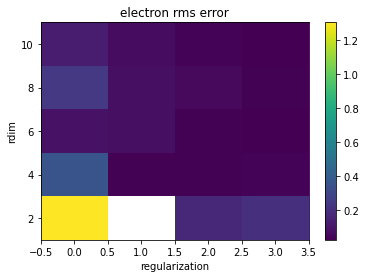

minimum: 0.06888937779971868
argmin: 18


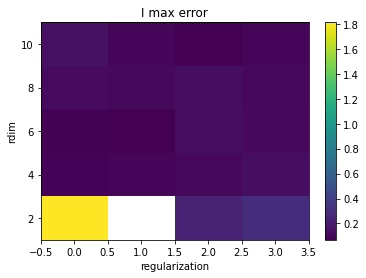

minimum: 0.07511444117534671
argmin: 4


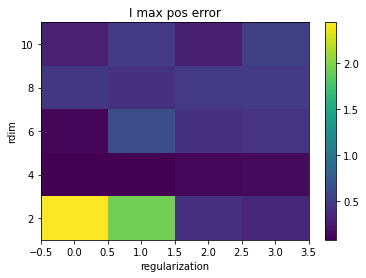

minimum: 0.07218766184907231
argmin: 8


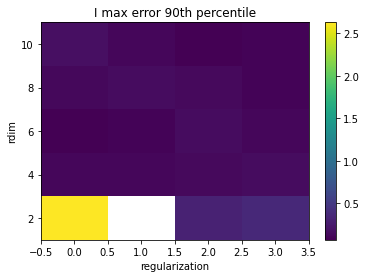

minimum: 0.04522613065326633
argmin: 13


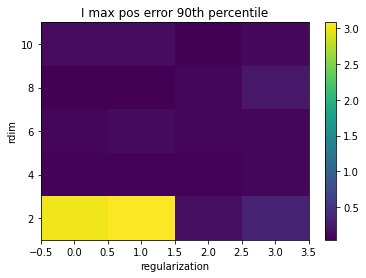

In [51]:
lims = [-0.5,3.5,1,11]

print('minimum:', np.nanmin(el_rms_err))
print('argmin:', np.nanargmin(el_rms_err))
plt.imshow(el_rms_err, origin='lower', aspect='auto', interpolation='none', extent=lims)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('electron rms error')

plt.show()


print('minimum:', np.nanmin(I_max_err))
print('argmin:', np.nanargmin(I_max_err))
plt.imshow(I_max_err, origin='lower', aspect='auto', interpolation='none', extent=lims)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('I max error')

plt.show()


print('minimum:', np.nanmin(I_max_pos_err))
print('argmin:', np.nanargmin(I_max_pos_err))
plt.imshow(I_max_pos_err, origin='lower', aspect='auto', interpolation='none', extent=lims)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('I max pos error')

plt.show()



print('minimum:', np.nanmin(I_max_err_90th))
print('argmin:', np.nanargmin(I_max_err_90th))
plt.imshow(I_max_err_90th, origin='lower', aspect='auto', interpolation='none', extent=lims)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('I max error 90th percentile')

plt.show()


print('minimum:', np.nanmin(I_max_pos_err_90th))
print('argmin:', np.nanargmin(I_max_pos_err_90th))
plt.imshow(I_max_pos_err_90th, origin='lower', aspect='auto', interpolation='none', extent=lims)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('I max pos error 90th percentile')

plt.show()



minimum: 0.00024151915708832075
argmin: 5


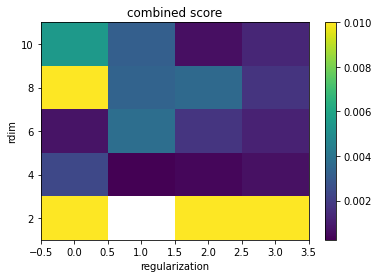

minimum: 0.006691813888393194
argmin: 4


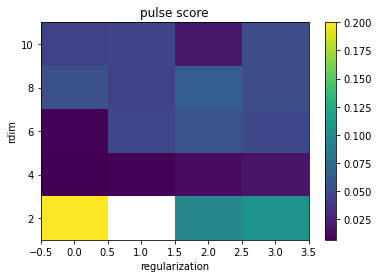

minimum: 0.164202688171312
argmin: 4


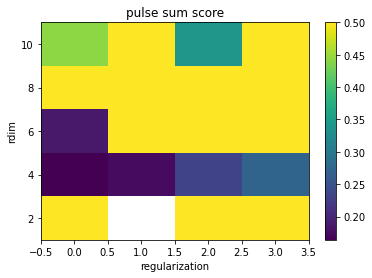

minimum: 0.13887090302249594
argmin: 18


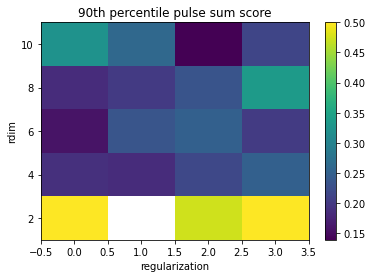

In [49]:
score = np.multiply(np.multiply(el_rms_err,I_max_err),I_max_pos_err)
print('minimum:', np.nanmin(score))
print('argmin:', np.nanargmin(score))

plt.imshow(score, origin='lower', aspect='auto', interpolation='none', extent=lims, vmax=0.01)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('combined score')

plt.show()


score = np.multiply(I_max_err,I_max_pos_err)
print('minimum:', np.nanmin(score))
print('argmin:', np.nanargmin(score))

plt.imshow(score, origin='lower', aspect='auto', interpolation='none', extent=lims, vmax=0.2)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('pulse score')

plt.show()



score = I_max_err + I_max_pos_err
print('minimum:', np.nanmin(score))
print('argmin:', np.nanargmin(score))

plt.imshow(score, origin='lower', aspect='auto', interpolation='none', extent=lims, vmax=0.5)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('pulse sum score')

plt.show()


score = I_max_err_90th + I_max_pos_err_90th
print('minimum:', np.nanmin(score))
print('argmin:', np.nanargmin(score))

plt.imshow(score, origin='lower', aspect='auto', interpolation='none', extent=lims, vmax=0.5)
plt.colorbar()
plt.ylabel('rdim')
plt.xlabel('regularization')
plt.title('90th percentile pulse sum score')

plt.show()

In [24]:
results = results_list[13]

print('electron rms error: ', str(results[0,0]) + ' +- ' + str(results[0,1]) )
print('I_max error: ', str(results[1,0]/mean_I_max) + ' +- ' + str(results[1,1]/mean_I_max) )
print('I_max_pos error: ', str(results[2,0]) + ' +- ' + str(results[2,1]) )
print('relative I_max error: ', str(results[3,0]) + ' +- ' + str(results[3,1]) )
print('relative I_max_pos error: ', str(results[4,0]) + ' +- ' + str(results[4,1]) )
print('median I_max error: ', str(results[5,0]/median_I_max))
print('90th percentile I_max error: ',str(results[5,1]/median_I_max) )
print('median I_max_pos error: ', str(results[6,0]), ' normalized: ', str(results[6,0]/median_I_max_pos) )
print('90th percentile I_max_pos error: ', str(results[6,1]), ' normalized: ', str(results[6,1]/median_I_max_pos)  )

electron rms error:  0.020950385974180166 +- 0.018282592662311293
I_max error:  0.04805955404512333 +- 0.04847890715608336
I_max_pos error:  74.2 +- 162.37105653410026
relative I_max error:  0.07917647398259031 +- 0.1505081546802293
relative I_max_pos error:  0.03282585517091199 +- 0.05186033900839992
median I_max error:  0.03767903367334251
90th percentile I_max error:  0.112562734931212
median I_max_pos error:  30.0  normalized:  0.015384615384615385
90th percentile I_max_pos error:  119.00000000000013  normalized:  0.06102564102564109


## Optimial configurations:


#### n = 100:
computation time: 1669s
meanstd pulse sum score: alpha_exp = 2, rdim = 4, 0.16420\
90th percentile pulse sum score: alpha_exp = 2, rdim = 10, 0.13887

#### n = 50: 
computation time: 760s\
meanstd pulse sum score: alpha_exp = 1, rdim = 8, 0.2121645\
90th percentile pulse sum score: alpha_exp = 1, rdim = 8, 0.17358

#### n = 20:
computation time: 306s\
meanstd pulse sum score: alpha_exp = 2, rdim = 4, 0.1806\
90th percentile pulse sum score: alpha_exp = 2, rdim = 4, 0.25143

#### n = 10:
computation time: 158s\
meanstd pulse sum score: alpha_exp = 2, rdim = 4, 0.272561\
90th percentile pulse sum score: alpha_exp = 0, rdim = 4, 0.303524